<a href="https://colab.research.google.com/github/dongjaeseo/colab/blob/main/luna16_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = 'drive/MyDrive/subset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install monai
!pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import json
from datetime import datetime

import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch import sigmoid


from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    Lambdad,
    LoadImaged,
    AddChanneld,
    ScaleIntensityRanged,
    BorderPadd,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    AsDiscreted,
    SelectItemsd,
    Resized,
    ToTensord
)
from monai.data import (
    Dataset, 
    CacheDataset, 
    DataLoader, 
    partition_dataset_classes
)
from monai.networks.nets import UNet, VNet
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.inferers import SlidingWindowInferer

from tqdm import trange, tqdm
import matplotlib.pyplot as plt
def imshow(x):
    plt.imshow(x, cmap='gray')
    plt.show()

In [26]:
datalist = json.load(open(f'{DATA_ROOT}/datalist.json'))
# print(datalist) {'image': 'images/1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004.nii.gz', 'label': 'labels/1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004.nii.gz'}

In [25]:
datalist = json.load(open(f'{DATA_ROOT}/datalist.json'))
print(len(datalist))
datalist = datalist[:50]
np.random.seed(42)
np.random.shuffle(datalist)
# ---- train:valid:test = 7:2:1
N = len(datalist)
cut1 = N*7//10
cut2 = N*9//10

train_ls = datalist[:cut1]
valid_ls = datalist[cut1:cut2]
test_ls = datalist[cut2:]

100


In [6]:
# PREPROCESSING

train_trans = Compose([
    Lambdad(
        keys=['image', 'label'],
        func=lambda p: f'{DATA_ROOT}/{p}'
    ),
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    # Spacing(..., pixdim=[3.0, 3.0, 3.0]),
    ScaleIntensityRanged(
        keys=['image'],
        a_min=-900, 
        a_max=300,
        b_min=0,
        b_max=1,
        clip=True
    ),
    BorderPadd(
        keys=['image', 'label'],
        spatial_border=[32, 32, 32]
    ),
    RandCropByPosNegLabeld(       # shape: (n, 1, 64, 64, 64)
        keys=['image', 'label'],
        label_key='label',
        spatial_size=[64, 64, 64],
        pos=1.0,
        neg=1.0,
        num_samples=4
    ),
    RandRotated(
        keys=['image', 'label'],
        prob=0.5,
        range_x=np.pi*20/180,
        range_y=np.pi*20/180,
        range_z=np.pi*10/180
    ),
    RandZoomd(
        keys=['image', 'label'],
        prob=0.5,
        min_zoom=0.8,
        max_zoom=1.2
    ),
    AsDiscreted( # rotated, zoomd
        keys=['label'],
        threshold=0.5
    ),
    ToTensord(
        keys=['image', 'label'],
    ),
    SelectItemsd(
        keys=['image', 'label'],
    )
])

valid_trans = Compose([
    Lambdad(
        keys=['image', 'label'],
        func=lambda p: f'{DATA_ROOT}/{p}'
    ),
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    # Spacing(..., pixdim=[3.0, 3.0, 3.0]),
    ScaleIntensityRanged(
        keys=['image'],
        a_min=-900, 
        a_max=300,
        b_min=0,
        b_max=1,
        clip=True
    ),
    ToTensord(
        keys=['image', 'label'],
    )
])


train_ds = CacheDataset(
    train_ls, 
    transform=train_trans, 
    num_workers=2, 
    cache_rate=1.0
)
valid_ds = CacheDataset(
    valid_ls, 
    transform=valid_trans, 
    num_workers=2, 
    cache_rate=1.0
)
test_ds = CacheDataset(
    test_ls, 
    transform=valid_trans, 
    num_workers=2, 
    cache_rate=1.0
)

# ---- batch_size = batch_size(dataloader)*num_samples(transform)
train_loader = DataLoader(
    train_ds,
    batch_size=5,
    shuffle=True,
    drop_last=True,
    num_workers=2
)
valid_loader = DataLoader(valid_ds, batch_size=1, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


torch.Size([1, 64, 64, 64])


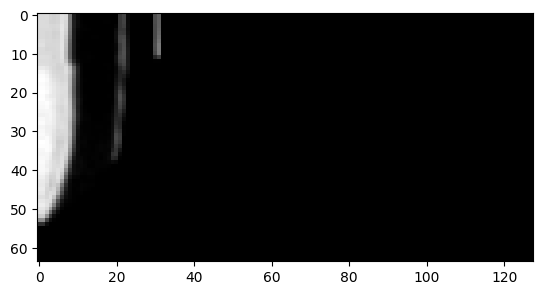

torch.Size([1, 64, 64, 64])


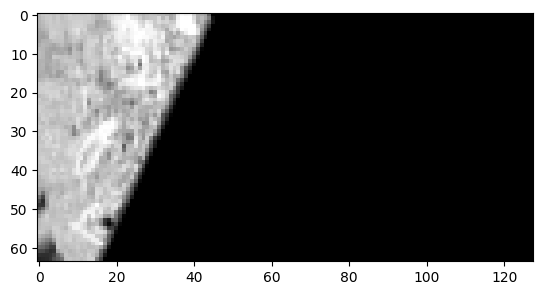

torch.Size([1, 64, 64, 64])


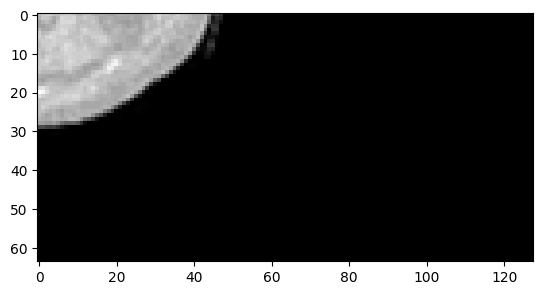

torch.Size([1, 64, 64, 64])


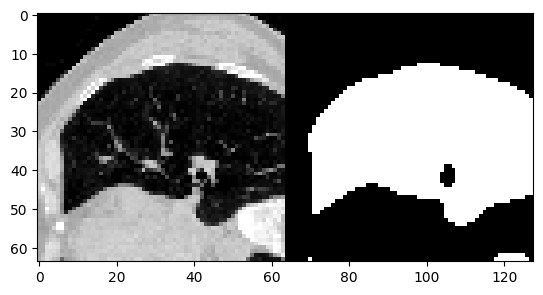

In [8]:
ls = train_ds[0]
for dt in ls:
    image = dt['image']
    print(image.shape)
    label = dt['label']
    D = image.shape[-1]
    image = image[0, :, :, D//2]
    label = label[0, :, :, D//2]*image.max()
    imshow(np.hstack([image, label]))

In [9]:
set_determinism(42) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[16, 32, 64],
    strides=[2, 2],
    num_res_units=0,
    dropout=0.0
).to(device)

loss = DiceLoss(sigmoid=True)
optimizer = Adam(model.parameters(), 1e-2)
infer = SlidingWindowInferer(
    roi_size=(64, 64, 64),
    sw_batch_size=8,
    overlap=0.25,
    mode='constant',
)

# Training

In [18]:
t_str = datetime.now().strftime("%y%m%d_%H%M%S")
writer = SummaryWriter(
    log_dir=f'drive/MyDrive/runs/{t_str}_Unetd3r0_LR_1e-2_ROI64')
max_epoch = 30

from tqdm import trange, tqdm
for i in trange(max_epoch):
    model.train()
    train_loss = 0
    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()      
        
        preds = model(images)      
        _loss = loss(preds, labels) 
        _loss.backward()           
    
        optimizer.step()            
        train_loss += _loss.item()

    train_loss /= len(train_loader)    
    _t = f'[epoch {(i+1):3d}/{max_epoch}] '
    _t += f'train loss: {train_loss:.3f} '
    writer.add_scalar('train_loss', train_loss, i)


    if (i+1) % 3 == 0:
        # evaluation
        model.eval()
        with torch.no_grad():
            valid_loss = 0
            for batch in valid_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
    
                preds = infer(images, model)
                _loss = loss(preds, labels)            
                valid_loss += _loss.item()
                
            valid_loss /= len(valid_loader)    
            _t += f'valid loss: {valid_loss:.3f} '
            writer.add_scalar('valid_loss', valid_loss, i)
    print(_t)
writer.close()

  3%|▎         | 1/30 [00:09<04:48,  9.96s/it]

[epoch   1/30] train loss: 0.711 


  7%|▋         | 2/30 [00:18<04:19,  9.28s/it]

[epoch   2/30] train loss: 0.704 


 10%|█         | 3/30 [00:29<04:25,  9.85s/it]

[epoch   3/30] train loss: 0.633 valid loss: 0.626 


 13%|█▎        | 4/30 [00:36<03:47,  8.74s/it]

[epoch   4/30] train loss: 0.644 


 17%|█▋        | 5/30 [00:44<03:37,  8.71s/it]

[epoch   5/30] train loss: 0.616 


 20%|██        | 6/30 [00:55<03:40,  9.19s/it]

[epoch   6/30] train loss: 0.623 valid loss: 0.455 


 23%|██▎       | 7/30 [01:02<03:16,  8.54s/it]

[epoch   7/30] train loss: 0.529 


 27%|██▋       | 8/30 [01:11<03:11,  8.69s/it]

[epoch   8/30] train loss: 0.564 


 30%|███       | 9/30 [01:21<03:10,  9.07s/it]

[epoch   9/30] train loss: 0.499 valid loss: 0.359 


 33%|███▎      | 10/30 [01:29<02:57,  8.90s/it]

[epoch  10/30] train loss: 0.490 


 37%|███▋      | 11/30 [01:38<02:49,  8.90s/it]

[epoch  11/30] train loss: 0.455 


 40%|████      | 12/30 [01:48<02:43,  9.11s/it]

[epoch  12/30] train loss: 0.429 valid loss: 0.285 


 43%|████▎     | 13/30 [01:56<02:32,  8.99s/it]

[epoch  13/30] train loss: 0.417 


 47%|████▋     | 14/30 [02:04<02:16,  8.50s/it]

[epoch  14/30] train loss: 0.455 


 50%|█████     | 15/30 [02:14<02:15,  9.03s/it]

[epoch  15/30] train loss: 0.466 valid loss: 0.313 


 53%|█████▎    | 16/30 [02:23<02:04,  8.87s/it]

[epoch  16/30] train loss: 0.414 


 57%|█████▋    | 17/30 [02:30<01:48,  8.34s/it]

[epoch  17/30] train loss: 0.462 


 60%|██████    | 18/30 [02:41<01:49,  9.15s/it]

[epoch  18/30] train loss: 0.394 valid loss: 0.237 


 63%|██████▎   | 19/30 [02:49<01:39,  9.04s/it]

[epoch  19/30] train loss: 0.433 


 67%|██████▋   | 20/30 [02:57<01:25,  8.54s/it]

[epoch  20/30] train loss: 0.375 


 70%|███████   | 21/30 [03:08<01:23,  9.33s/it]

[epoch  21/30] train loss: 0.390 valid loss: 0.225 


 73%|███████▎  | 22/30 [03:16<01:10,  8.78s/it]

[epoch  22/30] train loss: 0.372 


 77%|███████▋  | 23/30 [03:23<00:58,  8.39s/it]

[epoch  23/30] train loss: 0.339 


 80%|████████  | 24/30 [03:34<00:54,  9.11s/it]

[epoch  24/30] train loss: 0.335 valid loss: 0.161 


 83%|████████▎ | 25/30 [03:40<00:41,  8.36s/it]

[epoch  25/30] train loss: 0.389 


 87%|████████▋ | 26/30 [03:49<00:33,  8.47s/it]

[epoch  26/30] train loss: 0.353 


 90%|█████████ | 27/30 [04:00<00:27,  9.04s/it]

[epoch  27/30] train loss: 0.343 valid loss: 0.159 


 93%|█████████▎| 28/30 [04:06<00:16,  8.33s/it]

[epoch  28/30] train loss: 0.298 


 97%|█████████▋| 29/30 [04:15<00:08,  8.51s/it]

[epoch  29/30] train loss: 0.289 


100%|██████████| 30/30 [04:25<00:00,  8.85s/it]

[epoch  30/30] train loss: 0.338 valid loss: 0.161 


In [20]:
torch.save(model.state_dict(), '/content/drive/MyDrive/subset/model.pt')

# Testing

In [27]:
model.eval()
test_loss = 0
for batch in test_loader:
    labels = batch['label'].to(device)
    images = batch['image'].to(device)
    preds = infer(images, model)

    _loss = 1-compute_meandice(sigmoid(preds), labels)
    test_loss += _loss
test_loss /= len(test_loader)
print(f'test loss: {test_loss}')

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <function compute_meandice at 0x7fc922247c10>: Function `compute_meandice` has been deprecated since version 1.0.0. use `compute_dice` instead.
  warn_deprecated(obj, msg, warning_category)


test loss: tensor([[0.1570]], device='cuda:0', grad_fn=<AliasBackward0>)


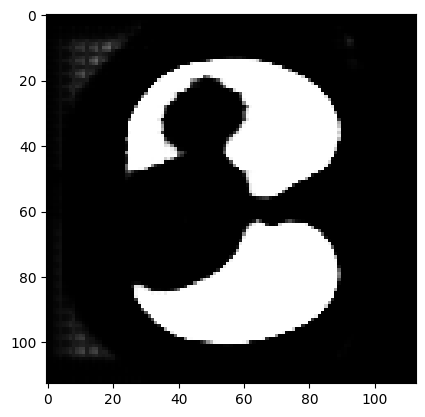

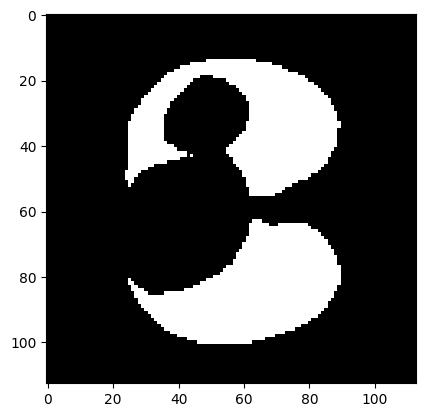

In [38]:
pred = sigmoid(preds).cpu().detach().numpy() # NCHWD
pred = pred[0]
C, H, W, D = pred.shape
#print(pred.shape) (1, 113, 113, 123)
imshow(pred[0,:,:,D//2])

label = batch['label'][0]
imshow(label[0,:,:,D//2])

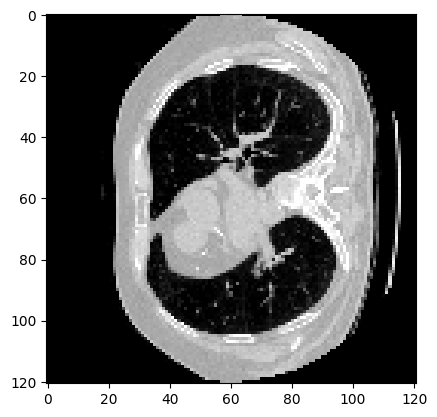

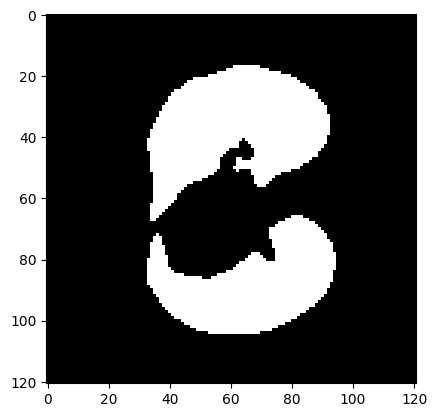

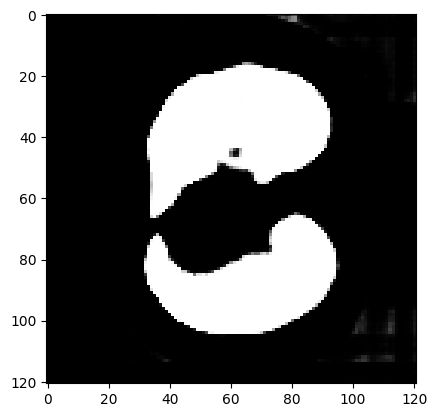

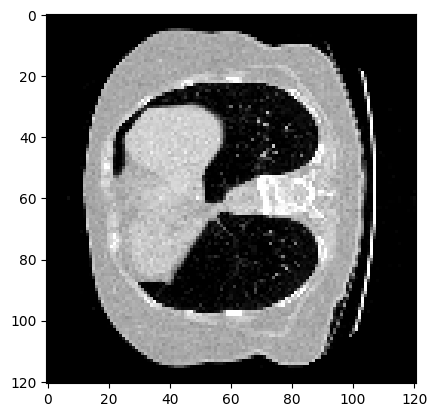

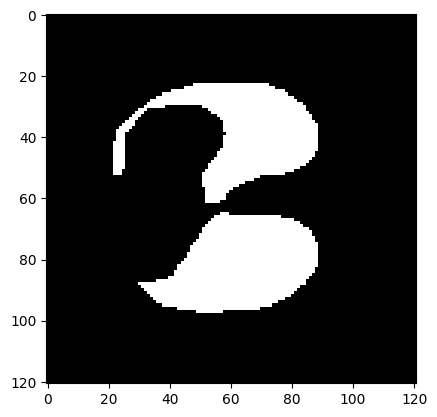

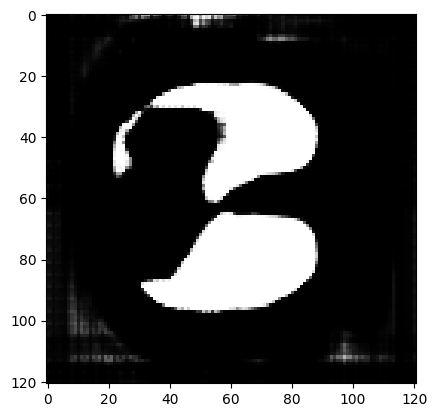

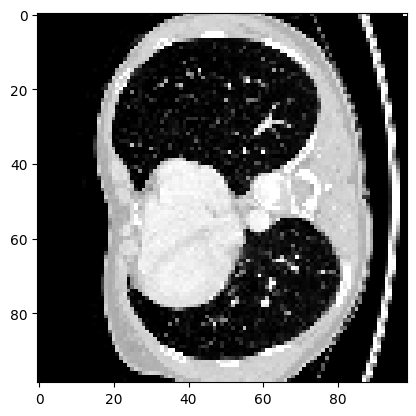

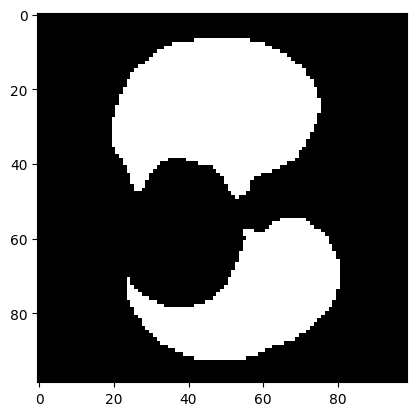

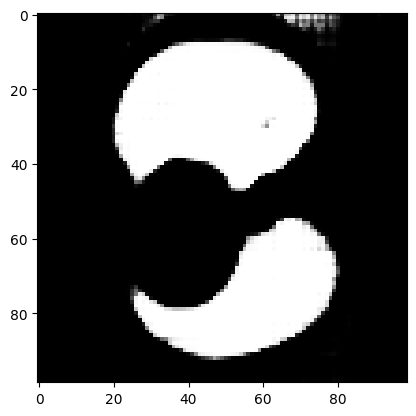

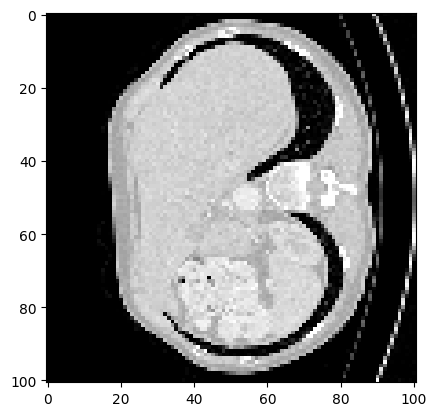

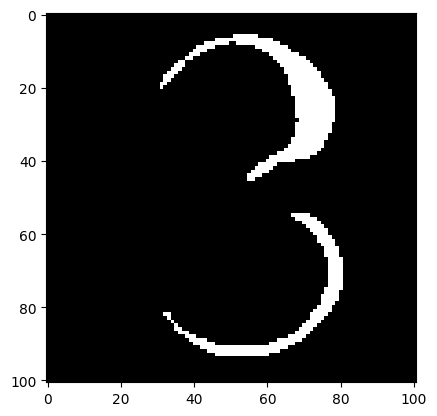

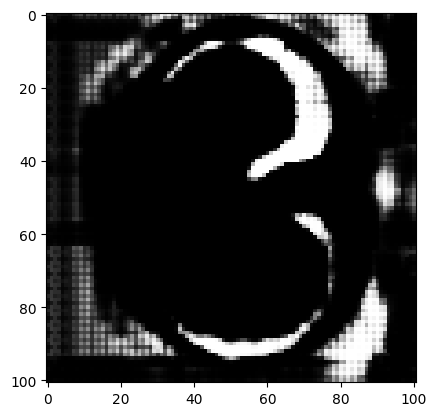

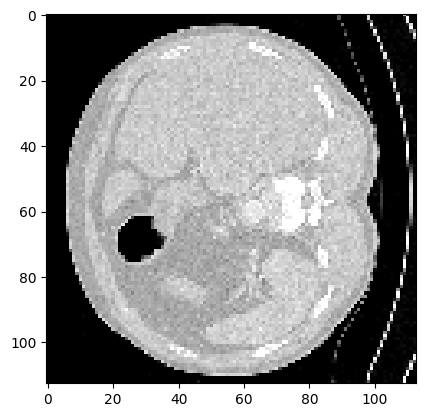

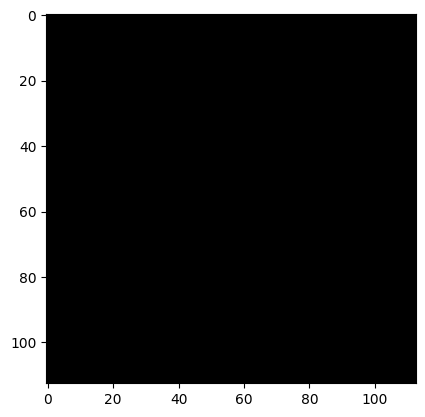

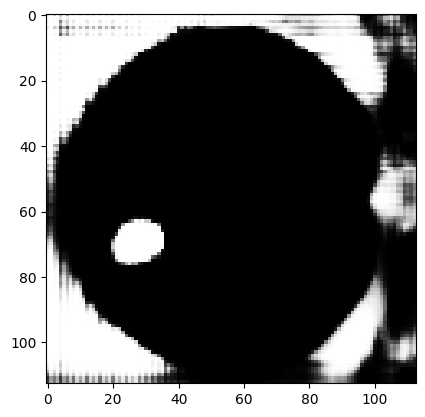

In [28]:
pred = sigmoid(preds).cpu().detach().numpy() 

i = 0
for batch in test_loader:
    labels = batch['label'].to(device)
    images = batch['image'].to(device)
    preds = infer(images, model)

    pred = sigmoid(preds).cpu().detach().numpy()
    pred1 = pred[0]

    label = batch['label'][0]
    image = batch['image'][0]
    imshow(image[0,:,:,D//2])
    imshow(label[0,:,:,D//2])
    
    imshow(pred1[0,:,:,D//2])

    i+= 1

    if i == 10:
        break